## File tuning scGPT for cell type annotation prediction

In [113]:
import warnings
from IPython.display import Image, display
warnings.filterwarnings(action='ignore')

### Download pretrained scGPT model:
https://drive.google.com/drive/folders/1oWh_-ZRdhtoGQ2Fw24HP41FgLoomVo-y

In [114]:
## https://scgpt.readthedocs.io/en/latest/tutorial_annotation.html#

import copy
import gc
import json
import os
from pathlib import Path
import shutil
import sys

import time
import traceback
from typing import List, Tuple, Dict, Union, Optional
import warnings
import pandas as pd
# from . import asyn
import pickle
import torch
from anndata import AnnData
import scanpy as sc
import scvi
import seaborn as sns
import numpy as np
from scipy.sparse import issparse
import matplotlib.pyplot as plt
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from torchtext.vocab import Vocab
from torchtext._torchtext import (
    Vocab as VocabPybind,
)
from sklearn.metrics import confusion_matrix

sys.path.insert(0, "../")

import scGPT.scgpt as scg
from scGPT.scgpt.model import TransformerModel
from scGPT.scgpt.tokenizer import tokenize_and_pad_batch, random_mask_value
from scGPT.scgpt.loss import (
    masked_mse_loss,
    masked_relative_error,
    criterion_neg_log_bernoulli,
)
from scGPT.scgpt.tokenizer.gene_tokenizer import GeneVocab
from scGPT.scgpt.preprocess import Preprocessor
from scGPT.scgpt import SubsetsBatchSampler
from scGPT.scgpt.utils import set_seed, category_str2int, eval_scib_metrics

sc.set_figure_params(figsize=(6, 6))
os.environ["KMP_WARNINGS"] = "off"
warnings.filterwarnings('ignore')

## Step1: Specify hyper-parameter setup for cell-type annotation task

In [115]:
hyperparameter_defaults = dict(
    seed=0,
    dataset_name="pangolin_heart",
    do_train=True,
    load_model="save/scGPT_human",
    mask_ratio=0.0,
    epochs=100,
    n_bins=51,
    MVC=False, # Masked value prediction for cell embedding
    ecs_thres=0.0, # Elastic cell similarity objective, 0.0 to 1.0, 0.0 to disable
    dab_weight=0.0,
    lr=1e-4,
    batch_size=32,
    layer_size=128,
    nlayers=4,  # number of nn.TransformerEncoderLayer in nn.TransformerEncoder
    nhead=4,  # number of heads in nn.MultiheadAttention
    dropout=0.2,  # dropout probability
    schedule_ratio=0.9,  # ratio of epochs for learning rate schedule
    save_eval_interval=5,
    fast_transformer=True,
    pre_norm=False,
    amp=True,  # Automatic Mixed Precision. Combines 16-bit (FP16) and 32-bit (FP32) floating-point calculations. 
    # FP16 reduces memory usage and speeds up computations.
    #FP32 is used when precision is critical
    include_zero_gene = False,
    freeze = False, #freeze
    DSBN = False,  # Domain-spec batchnorm
)

In [116]:
config=hyperparameter_defaults

In [117]:
# settings for input and preprocessing
pad_token = "<pad>"
special_tokens = [pad_token, "<cls>", "<eoc>"] # special tokens used for padding and marking the sequence
mask_ratio = config["mask_ratio"] # proportion of input tokens to mask for training
mask_value = "auto"  # for masked values, now it should always be auto

include_zero_gene = config["include_zero_gene"] # if True, include zero genes among HGVs in the training
max_seq_len = 3001
n_bins = config["n_bins"] # Number of bins for discretizing gene expression values

# input/output representation
input_style = "binned"  # "normed_raw", "log1p", or "binned"
output_style = "binned"  # "normed_raw", "log1p", or "binned"

# settings for training
MLM = False  # whether to use masked language modeling, currently it is always on.
CLS = True  # celltype classification objective
ADV = False  # Adversarial training for batch correction
CCE = False  # Contrastive cell embedding objective
MVC = config["MVC"]  # Masked value prediction for cell embedding
ECS = config["ecs_thres"] > 0 #config.ecs_thres > 0  # Elastic cell similarity objective
DAB = False  # Domain adaptation by reverse backpropagation, set to 2 for separate optimizer
INPUT_BATCH_LABELS = False  # TODO: have these help MLM and MVC, while not to classifier
input_emb_style = "continuous"  # "category" or "continuous" or "scaling"
cell_emb_style = "cls"  # "avg-pool" or "w-pool" or "cls"
adv_E_delay_epochs = 0  # delay adversarial training on encoder for a few epochs
adv_D_delay_epochs = 0
mvc_decoder_style = "inner product" # https://github.com/bowang-lab/scGPT/blob/7301b51a72f5db321fccebb51bc4dd1380d99023/scgpt/model/model.py
ecs_threshold = config["ecs_thres"] 
dab_weight = config["dab_weight"] 

explicit_zero_prob = MLM and include_zero_gene  # whether explicit bernoulli for zeros
do_sample_in_train = False and explicit_zero_prob  # sample the bernoulli in training

per_seq_batch_sample = False

# settings for optimizer
lr = config["lr"]  # TODO: test learning rate ratio between two tasks
batch_size = config["batch_size"] 
eval_batch_size = config["batch_size"] 
epochs = config["epochs"] 
schedule_interval = 1

# settings for the model
fast_transformer = config["fast_transformer"] # Whether to use a faster Transformer implementation.
fast_transformer_backend = "flash"  # "linear" or "flash"
embsize = config["layer_size"]  # embedding dimension
d_hid = config["layer_size"]  # dimension of the feedforward network in TransformerEncoder
nlayers = config["nlayers"]  # number of TransformerEncoderLayer in TransformerEncoder
nhead = config["nhead"]  # number of heads in nn.MultiheadAttention
dropout = config["dropout"] # dropout probability

# logging
log_interval = 100  # iterations
save_eval_interval = config["save_eval_interval"] # epochs
do_eval_scib_metrics = True
mask_value = -1
pad_value = -2
n_input_bins = n_bins

In [118]:
dataset_name = config["dataset_name"]
save_dir = Path(f"./save/dev_{dataset_name}-{time.strftime('%b%d-%H-%M')}/")
save_dir.mkdir(parents=True, exist_ok=True)
print(f"save to {save_dir}")
logger = scg.logger
scg.utils.add_file_handler(logger, save_dir / "run.log")

save to save/dev_pangolin_heart-May21-10-44


## Step 2: Load and pre-process data

In [119]:
data_dir = Path("../../data/pangolin")
adata = sc.read(data_dir / "pangoling_heart_train.h5ad")
adata_test = sc.read(data_dir / "pangoling_heart_test.h5ad")
# cell types
adata.obs["celltype"] = adata.obs["Celltype"].astype("category")
adata_test.obs["celltype"] = adata_test.obs["Celltype"].astype("category")

adata.obs["batch_id"] = adata.obs["str_batch"] = "0" # training data
print("Train data: ", adata.shape)
adata_test.obs["batch_id"] = adata_test.obs["str_batch"] = "1" # test data
print("Test data: ", adata_test.shape)

Train data:  (10366, 21627)
Test data:  (2592, 21627)


In [120]:
adata.var.set_index(adata.var.index, inplace=True)
adata_test.var.set_index(adata.var.index, inplace=True)
data_is_raw = False

filter_gene_by_counts = False
adata_test_raw = adata_test.copy()
adata = adata.concatenate(adata_test, batch_key="str_batch")

# make the batch category column
batch_id_labels = adata.obs["str_batch"].astype("category").cat.codes.values
adata.obs["batch_id"] = batch_id_labels
celltype_id_labels = adata.obs["celltype"].astype("category").cat.codes.values
celltypes = adata.obs["celltype"].unique()
num_types = len(np.unique(celltype_id_labels))
id2type = dict(enumerate(adata.obs["celltype"].astype("category").cat.categories))
adata.obs["celltype_id"] = celltype_id_labels
adata.var["gene_name"] = adata.var.index.tolist()

In [121]:
adata.obs["celltype"]

Cells
GAAGTAACAAATGCGG-0        Cardiomyocytes
TCAAGTGTCGTTATCT-0           Macrophages
CTCCCTCAGGACAGTC-0        Cardiomyocytes
ACTCCCAGTGCATGTT-0        Cardiomyocytes
CTCCACACACGGGTAA-0        Cardiomyocytes
                             ...        
ATGCATGAGTGCAAAT-1    Smooth muscle cell
ACTCTCGGTAACGTTC-1        Cardiomyocytes
CCCTAACAGCAACCAG-1             Pericytes
GCCAACGCACCTATCC-1    Smooth muscle cell
GTGTGGCTCCTAGCCT-1        Cardiomyocytes
Name: celltype, Length: 12958, dtype: category
Categories (7, object): ['Cardiomyocytes', 'Endothelial cell', 'Epicardial cells', 'Fibroblasts', 'Macrophages', 'Pericytes', 'Smooth muscle cell']

In [122]:
adata.X, adata.X.shape

(array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 2.32859858, 0.        ,
         4.25528088],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         1.99789063],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         2.77669985],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         4.62793372],
        [1.66547124, 0.        , 0.        , ..., 0.        , 0.        ,
         2.62933118]]),
 (12958, 21627))

In [123]:
adata_test.X, adata_test.X.shape

(array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         3.64735925],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         1.91847659],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         2.77669985],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         4.62793372],
        [1.66547124, 0.        , 0.        , ..., 0.        , 0.        ,
         2.62933118]]),
 (2592, 21627))

In [124]:
if config["load_model"] is not None:
    model_dir = Path(config["load_model"])
    model_config_file = model_dir / "args.json"
    model_file = model_dir / "best_model.pt"
    vocab_file = model_dir / "vocab.json"

    vocab = GeneVocab.from_file(vocab_file)
    print(vocab)
    shutil.copy(vocab_file, save_dir / "vocab.json")
    for s in special_tokens:
        if s not in vocab:
            vocab.append_token(s)

    adata.var["id_in_vocab"] = [
        1 if gene in vocab else -1 for gene in adata.var["gene_name"]
    ]
    gene_ids_in_vocab = np.array(adata.var["id_in_vocab"])
    logger.info(
        f"match {np.sum(gene_ids_in_vocab >= 0)}/{len(gene_ids_in_vocab)} genes "
        f"in vocabulary of size {len(vocab)}."
    )
    adata = adata[:, adata.var["id_in_vocab"] >= 0]

    # model
    with open(model_config_file, "r") as f:
        model_configs = json.load(f)
    logger.info(
        f"Resume model from {model_file}, the model args will override the "
        f"config {model_config_file}."
    )
    embsize = model_configs["embsize"]
    nhead = model_configs["nheads"]
    d_hid = model_configs["d_hid"]
    nlayers = model_configs["nlayers"]
    n_layers_cls = model_configs["n_layers_cls"]

GeneVocab()
scGPT - INFO - match 14034/21627 genes in vocabulary of size 60697.
scGPT - INFO - Resume model from save/scGPT_human/best_model.pt, the model args will override the config save/scGPT_human/args.json.


In [125]:
# set up the preprocessor, use the args to config the workflow
preprocessor = Preprocessor(
    use_key="X",  # the key in adata.layers to use as raw data
    filter_gene_by_counts=filter_gene_by_counts,  # step 1
    filter_cell_by_counts=False,  # step 2
    normalize_total=1e4,  # step 3. whether to normalize the raw data and to what sum
    result_normed_key="X_normed",  # the key in adata.layers to store the normalized data
    log1p=data_is_raw,  # step 4. whether to log1p the normalized data
    result_log1p_key="X_log1p",
    subset_hvg=1500,  # step 5. whether to subset the raw data to highly variable genes
    hvg_flavor="seurat_v3" if data_is_raw else "cell_ranger",
    binning=n_bins,  # step 6. whether to bin the raw data and to what number of bins
    result_binned_key="X_binned",  # the key in adata.layers to store the binned data
)

adata_test = adata[adata.obs["str_batch"] == "1"]
adata = adata[adata.obs["str_batch"] == "0"]

preprocessor(adata, batch_key=None)
preprocessor(adata_test, batch_key=None)
print("Train data: ", adata.shape)
print("Test data: ", adata_test.shape)

scGPT - INFO - Normalizing total counts ...
scGPT - INFO - Subsetting highly variable genes ...
scGPT - WARNING - No batch_key is provided, will use all cells for HVG selection.
scGPT - INFO - Binning data ...
scGPT - INFO - Normalizing total counts ...
scGPT - INFO - Subsetting highly variable genes ...
scGPT - WARNING - No batch_key is provided, will use all cells for HVG selection.
scGPT - INFO - Binning data ...
Train data:  (10366, 1500)
Test data:  (2592, 1500)


In [126]:
input_layer_key = {  # the values of this map coorespond to the keys in preprocessing
    "normed_raw": "X_normed",
    "log1p": "X_normed",
    "binned": "X_binned",
}[input_style]
all_counts = (
    adata.layers[input_layer_key].A
    if issparse(adata.layers[input_layer_key])
    else adata.layers[input_layer_key]
)
genes = adata.var["gene_name"].tolist()

celltypes_labels = adata.obs["celltype_id"].tolist()  # make sure count from 0
celltypes_labels = np.array(celltypes_labels)

batch_ids = adata.obs["batch_id"].tolist()
num_batch_types = len(set(batch_ids))
batch_ids = np.array(batch_ids)

(
    train_data,
    valid_data,
    train_celltype_labels,
    valid_celltype_labels,
    train_batch_labels,
    valid_batch_labels,
) = train_test_split(
    all_counts, celltypes_labels, batch_ids, test_size=0.1, shuffle=True
)

In [127]:
train_data.shape, train_batch_labels.shape, valid_data.shape, valid_batch_labels.shape

((9329, 1500), (9329,), (1037, 1500), (1037,))

In [128]:
if config["load_model"] is None:
    vocab = Vocab(VocabPybind(genes + special_tokens, None))  
    # bidirectional lookup [gene <-> int]
vocab.set_default_index(vocab["<pad>"])
gene_ids = np.array(vocab(genes), dtype=int)
gene_ids, special_tokens

(array([16134, 20559,  4747, ..., 35786,  4620,  1802]),
 ['<pad>', '<cls>', '<eoc>'])

In [129]:
tokenized_train = tokenize_and_pad_batch(
    train_data,
    gene_ids,
    max_len=max_seq_len,
    vocab=vocab,
    pad_token=pad_token,
    pad_value=pad_value,
    append_cls=True,  # append <cls> token at the beginning
    include_zero_gene=include_zero_gene,
)
tokenized_valid = tokenize_and_pad_batch(
    valid_data,
    gene_ids,
    max_len=max_seq_len,
    vocab=vocab,
    pad_token=pad_token,
    pad_value=pad_value,
    append_cls=True,
    include_zero_gene=include_zero_gene,
)
logger.info(
    f"train set number of samples: {tokenized_train['genes'].shape[0]}, "
    f"\n\t feature length: {tokenized_train['genes'].shape[1]}"
)
logger.info(
    f"valid set number of samples: {tokenized_valid['genes'].shape[0]}, "
    f"\n\t feature length: {tokenized_valid['genes'].shape[1]}"
)

scGPT - INFO - train set number of samples: 9329, 
	 feature length: 603
scGPT - INFO - valid set number of samples: 1037, 
	 feature length: 466


In [130]:
def prepare_data(sort_seq_batch=False) -> Tuple[Dict[str, torch.Tensor]]:
    masked_values_train = random_mask_value(
        tokenized_train["values"],
        mask_ratio=mask_ratio,
        mask_value=mask_value,
        pad_value=pad_value,
    )
    masked_values_valid = random_mask_value(
        tokenized_valid["values"],
        mask_ratio=mask_ratio,
        mask_value=mask_value,
        pad_value=pad_value,
    )
    print(
        f"random masking at epoch {epoch:3d}, ratio of masked values in train: ",
        f"{(masked_values_train == mask_value).sum() / (masked_values_train - pad_value).count_nonzero():.4f}",
    )

    input_gene_ids_train, input_gene_ids_valid = (
        tokenized_train["genes"],
        tokenized_valid["genes"],
    )
    input_values_train, input_values_valid = masked_values_train, masked_values_valid
    target_values_train, target_values_valid = (
        tokenized_train["values"],
        tokenized_valid["values"],
    )

    tensor_batch_labels_train = torch.from_numpy(train_batch_labels).long()
    tensor_batch_labels_valid = torch.from_numpy(valid_batch_labels).long()

    tensor_celltype_labels_train = torch.from_numpy(train_celltype_labels).long()
    tensor_celltype_labels_valid = torch.from_numpy(valid_celltype_labels).long()

    if sort_seq_batch:  # TODO: update to random pick seq source in each traning batch
        train_sort_ids = np.argsort(train_batch_labels)
        input_gene_ids_train = input_gene_ids_train[train_sort_ids]
        input_values_train = input_values_train[train_sort_ids]
        target_values_train = target_values_train[train_sort_ids]
        tensor_batch_labels_train = tensor_batch_labels_train[train_sort_ids]
        tensor_celltype_labels_train = tensor_celltype_labels_train[train_sort_ids]

        valid_sort_ids = np.argsort(valid_batch_labels)
        input_gene_ids_valid = input_gene_ids_valid[valid_sort_ids]
        input_values_valid = input_values_valid[valid_sort_ids]
        target_values_valid = target_values_valid[valid_sort_ids]
        tensor_batch_labels_valid = tensor_batch_labels_valid[valid_sort_ids]
        tensor_celltype_labels_valid = tensor_celltype_labels_valid[valid_sort_ids]

    train_data_pt = {
        "gene_ids": input_gene_ids_train,
        "values": input_values_train,
        "target_values": target_values_train,
        "batch_labels": tensor_batch_labels_train,
        "celltype_labels": tensor_celltype_labels_train,
    }
    valid_data_pt = {
        "gene_ids": input_gene_ids_valid,
        "values": input_values_valid,
        "target_values": target_values_valid,
        "batch_labels": tensor_batch_labels_valid,
        "celltype_labels": tensor_celltype_labels_valid,
    }

    return train_data_pt, valid_data_pt


# dataset
class SeqDataset(Dataset):
    def __init__(self, data: Dict[str, torch.Tensor]):
        self.data = data

    def __len__(self):
        return self.data["gene_ids"].shape[0]

    def __getitem__(self, idx):
        return {k: v[idx] for k, v in self.data.items()}


# data_loader
def prepare_dataloader(
    data_pt: Dict[str, torch.Tensor],
    batch_size: int,
    shuffle: bool = False,
    intra_domain_shuffle: bool = False,
    drop_last: bool = False,
    num_workers: int = 0,
) -> DataLoader:
    if num_workers == 0:
        num_workers = min(len(os.sched_getaffinity(0)), batch_size // 2)

    dataset = SeqDataset(data_pt)

    if per_seq_batch_sample:
        # find the indices of samples in each seq batch
        subsets = []
        batch_labels_array = data_pt["batch_labels"].numpy()
        for batch_label in np.unique(batch_labels_array):
            batch_indices = np.where(batch_labels_array == batch_label)[0].tolist()
            subsets.append(batch_indices)
        data_loader = DataLoader(
            dataset=dataset,
            batch_sampler=SubsetsBatchSampler(
                subsets,
                batch_size,
                intra_subset_shuffle=intra_domain_shuffle,
                inter_subset_shuffle=shuffle,
                drop_last=drop_last,
            ),
            num_workers=num_workers,
            pin_memory=True,
        )
        return data_loader

    data_loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers,
        pin_memory=True,
    )
    return data_loader

## Step 3: Load the pre-trained scGPT model

In [131]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

ntokens = len(vocab)  # size of vocabulary
model = TransformerModel(
    ntokens,
    embsize,
    nhead,
    d_hid,
    nlayers,
    nlayers_cls=3,
    n_cls=num_types if CLS else 1,
    vocab=vocab,
    dropout=dropout,
    pad_token=pad_token,
    pad_value=pad_value,
    do_mvc=MVC,
    do_dab=DAB,
    use_batch_labels=INPUT_BATCH_LABELS,
    num_batch_labels=num_batch_types,
    domain_spec_batchnorm=config["DSBN"],
    input_emb_style=input_emb_style,
    # This continuous embedding style aligns with the model's ability to handle various types of single-cell data, 
    # including gene expression values, which are inherently continuous
    n_input_bins=n_input_bins,
    cell_emb_style=cell_emb_style,
    mvc_decoder_style=mvc_decoder_style,
    ecs_threshold=ecs_threshold,
    explicit_zero_prob=explicit_zero_prob,
    use_fast_transformer=fast_transformer,
    fast_transformer_backend=fast_transformer_backend,
    pre_norm=config["pre_norm"],
)
if config["load_model"] is not None:
    try:
        model.load_state_dict(torch.load(model_file)) # map_location=torch.device('cpu')
        logger.info(f"Loading all model params from {model_file}")
    except:
        # only load params that are in the model and match the size
        model_dict = model.state_dict()
        pretrained_dict = torch.load(model_file) #  map_location=torch.device('cpu')
        pretrained_dict = {
            k: v
            for k, v in pretrained_dict.items()
            if k in model_dict and v.shape == model_dict[k].shape
        }
        for k, v in pretrained_dict.items():
            logger.info(f"Loading params {k} with shape {v.shape}")
        model_dict.update(pretrained_dict)
        model.load_state_dict(model_dict)

pre_freeze_param_count = sum(dict((p.data_ptr(), p.numel()) for p in model.parameters() if p.requires_grad).values())

# Freeze all pre-decoder weights
for name, para in model.named_parameters():
    print("-"*20)
    print(f"name: {name}")
    if config["freeze"] and "encoder" in name and "transformer_encoder" not in name:
        print(f"freezing weights for: {name}")
        para.requires_grad = False

post_freeze_param_count = sum(dict((p.data_ptr(), p.numel()) for p in model.parameters() if p.requires_grad).values())

logger.info(f"Total Pre freeze Params {(pre_freeze_param_count )}")
logger.info(f"Total Post freeze Params {(post_freeze_param_count )}")

model.to(device)

cuda
scGPT - INFO - Loading params encoder.embedding.weight with shape torch.Size([60697, 512])
scGPT - INFO - Loading params encoder.enc_norm.weight with shape torch.Size([512])
scGPT - INFO - Loading params encoder.enc_norm.bias with shape torch.Size([512])
scGPT - INFO - Loading params value_encoder.linear1.weight with shape torch.Size([512, 1])
scGPT - INFO - Loading params value_encoder.linear1.bias with shape torch.Size([512])
scGPT - INFO - Loading params value_encoder.linear2.weight with shape torch.Size([512, 512])
scGPT - INFO - Loading params value_encoder.linear2.bias with shape torch.Size([512])
scGPT - INFO - Loading params value_encoder.norm.weight with shape torch.Size([512])
scGPT - INFO - Loading params value_encoder.norm.bias with shape torch.Size([512])
scGPT - INFO - Loading params transformer_encoder.layers.0.self_attn.out_proj.weight with shape torch.Size([512, 512])
scGPT - INFO - Loading params transformer_encoder.layers.0.self_attn.out_proj.bias with shape tor

TransformerModel(
  (encoder): GeneEncoder(
    (embedding): Embedding(60697, 512, padding_idx=60694)
    (enc_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (value_encoder): ContinuousValueEncoder(
    (dropout): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=1, out_features=512, bias=True)
    (activation): ReLU()
    (linear2): Linear(in_features=512, out_features=512, bias=True)
    (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-11): 12 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=512, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (linear2): Linear(in_features=512, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, el

In [132]:
criterion = masked_mse_loss
criterion_cls = nn.CrossEntropyLoss()
criterion_dab = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    model.parameters(), lr=lr, eps=1e-4 if config["amp"] else 1e-8
)
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer, schedule_interval, gamma=config["schedule_ratio"]
)
scaler = torch.cuda.amp.GradScaler(enabled=config["amp"])

In [133]:
def train(model: nn.Module, loader: DataLoader) -> None:
    """
    Train the model for one epoch.
    """
    model.train()
    (
        total_loss,
        total_mse,
        total_cls,
        total_cce,
        total_mvc,
        total_ecs,
        total_dab,
        total_adv_E,
        total_adv_D,
        total_zero_log_prob,
        total_mvc_zero_log_prob,
    ) = (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
    total_error = 0.0
    start_time = time.time()

    num_batches = len(loader)
    for batch, batch_data in enumerate(loader):
        input_gene_ids = batch_data["gene_ids"].to(device)
        input_values = batch_data["values"].to(device)
        target_values = batch_data["target_values"].to(device)
        batch_labels = batch_data["batch_labels"].to(device)
        celltype_labels = batch_data["celltype_labels"].to(device)

        src_key_padding_mask = input_gene_ids.eq(vocab[pad_token])
        with torch.cuda.amp.autocast(enabled=config["amp"]):
            output_dict = model(
                input_gene_ids,
                input_values,
                src_key_padding_mask=src_key_padding_mask,
                batch_labels=batch_labels if INPUT_BATCH_LABELS or config["DSBN"] else None,
                CLS=CLS,
                CCE=CCE,
                MVC=MVC,
                ECS=ECS,
                do_sample=do_sample_in_train,
            )

            masked_positions = input_values.eq(mask_value)  # the postions to predict
            loss = 0.0
            metrics_to_log = {}
            
            if CLS:
                loss_cls = criterion_cls(output_dict["cls_output"], celltype_labels)
                loss = loss + loss_cls
                metrics_to_log.update({"train/cls": loss_cls.item()})

                error_rate = 1 - (
                    (output_dict["cls_output"].argmax(1) == celltype_labels)
                    .sum()
                    .item()
                ) / celltype_labels.size(0)
            

        model.zero_grad()
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        with warnings.catch_warnings(record=True) as w:
            warnings.filterwarnings("always")
            torch.nn.utils.clip_grad_norm_(
                model.parameters(),
                1.0,
                error_if_nonfinite=False if scaler.is_enabled() else True,
            )
            if len(w) > 0:
                logger.warning(
                    f"Found infinite gradient. This may be caused by the gradient "
                    f"scaler. The current scale is {scaler.get_scale()}. This warning "
                    "can be ignored if no longer occurs after autoscaling of the scaler."
                )
        scaler.step(optimizer)
        scaler.update()

        
        total_loss += loss.item()
        total_cls += loss_cls.item() if CLS else 0.0
        total_zero_log_prob += loss_zero_log_prob.item() if explicit_zero_prob else 0.0
        total_mvc_zero_log_prob += (
            loss_mvc_zero_log_prob.item() if MVC and explicit_zero_prob else 0.0
        )
        total_error += error_rate
        if batch % log_interval == 0 and batch > 0:
            lr = scheduler.get_last_lr()[0]
            ms_per_batch = (time.time() - start_time) * 1000 / log_interval
            cur_loss = total_loss / log_interval
            cur_mse = total_mse / log_interval
            cur_cls = total_cls / log_interval if CLS else 0.0
            cur_zero_log_prob = (
                total_zero_log_prob / log_interval if explicit_zero_prob else 0.0
            )
            cur_mvc_zero_log_prob = (
                total_mvc_zero_log_prob / log_interval
                if MVC and explicit_zero_prob
                else 0.0
            )
            cur_error = total_error / log_interval
            logger.info(
                f"| epoch {epoch:3d} | {batch:3d}/{num_batches:3d} batches | "
                f"lr {lr:05.4f} | ms/batch {ms_per_batch:5.2f} | "
                f"loss {cur_loss:5.2f} | "
                + (f"mse {cur_mse:5.2f} | mre {cur_error:5.2f} |" if MLM else "")
                + (f"cls {cur_cls:5.2f} | " if CLS else "")
                + (f"err {cur_error:5.2f} | " if CLS else "")
                + (f"cce {cur_cce:5.2f} |" if CCE else "")
                + (f"mvc {cur_mvc:5.2f} |" if MVC else "")
                + (f"ecs {cur_ecs:5.2f} |" if ECS else "")
                + (f"dab {cur_dab:5.2f} |" if DAB else "")
                + (f"adv_E {cur_adv_E:5.2f} |" if ADV else "")
                + (f"adv_D {cur_adv_D:5.2f} |" if ADV else "")
                + (f"nzlp {cur_zero_log_prob:5.2f} |" if explicit_zero_prob else "")
                + (
                    f"mvc_nzlp {cur_mvc_zero_log_prob:5.2f} |"
                    if MVC and explicit_zero_prob
                    else ""
                )
            )
            total_loss = 0
            total_mse = 0
            total_cls = 0
            total_zero_log_prob = 0
            total_mvc_zero_log_prob = 0
            total_error = 0
            start_time = time.time()


def evaluate(model: nn.Module, loader: DataLoader, return_raw: bool = False) -> float:
    """
    Evaluate the model on the evaluation data.
    """
    model.eval()
    total_loss = 0.0
    total_error = 0.0
    total_dab = 0.0
    total_num = 0
    predictions = []
    with torch.no_grad():
        for batch_data in loader:
            input_gene_ids = batch_data["gene_ids"].to(device)
            input_values = batch_data["values"].to(device)
            target_values = batch_data["target_values"].to(device)
            batch_labels = batch_data["batch_labels"].to(device)
            celltype_labels = batch_data["celltype_labels"].to(device)

            src_key_padding_mask = input_gene_ids.eq(vocab[pad_token])
            with torch.cuda.amp.autocast(enabled=config["amp"]):
                output_dict = model(
                    input_gene_ids,
                    input_values,
                    src_key_padding_mask=src_key_padding_mask,
                    batch_labels=batch_labels if INPUT_BATCH_LABELS or config["DSBN"] else None,
                    CLS=CLS,  # evaluation does not need CLS or CCE
                    CCE=False,
                    MVC=False,
                    ECS=False,
                    do_sample=do_sample_in_train,
                    #generative_training = False,
                )
                output_values = output_dict["cls_output"]
                loss = criterion_cls(output_values, celltype_labels)

                if DAB:
                    loss_dab = criterion_dab(output_dict["dab_output"], batch_labels)

            total_loss += loss.item() * len(input_gene_ids)
            accuracy = (output_values.argmax(1) == celltype_labels).sum().item()
            total_error += (1 - accuracy / len(input_gene_ids)) * len(input_gene_ids)
            total_dab += loss_dab.item() * len(input_gene_ids) if DAB else 0.0
            total_num += len(input_gene_ids)
            preds = output_values.argmax(1).cpu().numpy()
            predictions.append(preds)

    if return_raw:
        return np.concatenate(predictions, axis=0)

    return total_loss / total_num, total_error / total_num


## Step 4: Finetune scGPT with task-specific objectives

In [134]:
best_val_loss = float("inf")
best_avg_bio = 0.0
best_model = None

for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    train_data_pt, valid_data_pt = prepare_data(sort_seq_batch=per_seq_batch_sample)
    train_loader = prepare_dataloader(
        train_data_pt,
        batch_size=batch_size,
        shuffle=False,
        intra_domain_shuffle=True,
        drop_last=False,
    )
    valid_loader = prepare_dataloader(
        valid_data_pt,
        batch_size=eval_batch_size,
        shuffle=False,
        intra_domain_shuffle=False,
        drop_last=False,
    )

    if config["do_train"]:
        train(
            model,
            loader=train_loader,
        )
    val_loss, val_err = evaluate(
        model,
        loader=valid_loader,
    )
    elapsed = time.time() - epoch_start_time
    logger.info("-" * 89)
    logger.info(
        f"| end of epoch {epoch:3d} | time: {elapsed:5.2f}s | "
        f"valid loss/mse {val_loss:5.4f} | err {val_err:5.4f}"
    )
    logger.info("-" * 89)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = copy.deepcopy(model)
        best_model_epoch = epoch
        logger.info(f"Best model with score {best_val_loss:5.4f}")

    scheduler.step()

random masking at epoch   1, ratio of masked values in train:  0.0000
scGPT - INFO - | epoch   1 | 100/292 batches | lr 0.0001 | ms/batch 221.40 | loss  1.02 | cls  1.02 | err  0.37 | 
scGPT - INFO - | epoch   1 | 200/292 batches | lr 0.0001 | ms/batch 210.69 | loss  0.42 | cls  0.42 | err  0.14 | 
scGPT - INFO - -----------------------------------------------------------------------------------------
scGPT - INFO - | end of epoch   1 | time: 65.13s | valid loss/mse 0.5831 | err 0.1572
scGPT - INFO - -----------------------------------------------------------------------------------------
scGPT - INFO - Best model with score 0.5831
random masking at epoch   2, ratio of masked values in train:  0.0000
scGPT - INFO - | epoch   2 | 100/292 batches | lr 0.0001 | ms/batch 220.68 | loss  0.33 | cls  0.33 | err  0.10 | 
scGPT - INFO - | epoch   2 | 200/292 batches | lr 0.0001 | ms/batch 211.06 | loss  0.27 | cls  0.27 | err  0.09 | 
scGPT - INFO - ---------------------------------------------

### Predictions on test data

In [135]:
# %% inference
def test(model: nn.Module, adata: DataLoader) -> float:
    all_counts = (
        adata.layers[input_layer_key].A
        if issparse(adata.layers[input_layer_key])
        else adata.layers[input_layer_key]
    )

    celltypes_labels = adata.obs["celltype_id"].tolist()  # make sure count from 0
    celltypes_labels = np.array(celltypes_labels)

    batch_ids = adata.obs["batch_id"].tolist()
    batch_ids = np.array(batch_ids)

    tokenized_test = tokenize_and_pad_batch(
        all_counts,
        gene_ids,
        max_len=max_seq_len,
        vocab=vocab,
        pad_token=pad_token,
        pad_value=pad_value,
        append_cls=True,  # append <cls> token at the beginning
        include_zero_gene=include_zero_gene,
    )

    input_values_test = random_mask_value(
        tokenized_test["values"],
        mask_ratio=mask_ratio,
        mask_value=mask_value,
        pad_value=pad_value,
    )

    test_data_pt = {
        "gene_ids": tokenized_test["genes"],
        "values": input_values_test,
        "target_values": tokenized_test["values"],
        "batch_labels": torch.from_numpy(batch_ids).long(),
        "celltype_labels": torch.from_numpy(celltypes_labels).long(),
    }

    test_loader = DataLoader(
        dataset=SeqDataset(test_data_pt),
        batch_size=eval_batch_size,
        shuffle=False,
        drop_last=False,
        num_workers=min(len(os.sched_getaffinity(0)), eval_batch_size // 2),
        pin_memory=True, # Copies the tensor to pinned memory, if it’s not already pinned.
    )

    model.eval()
    predictions = evaluate(
        model,
        loader=test_loader,
        return_raw=True,
    )

    # compute accuracy, precision, recall, f1
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

    accuracy = accuracy_score(celltypes_labels, predictions)
    precision = precision_score(celltypes_labels, predictions, average="macro")
    recall = recall_score(celltypes_labels, predictions, average="macro")
    macro_f1 = f1_score(celltypes_labels, predictions, average="macro")

    logger.info(
        f"Accuracy: {accuracy:.3f}, Precision: {precision:.3f}, Recall: {recall:.3f}, "
        f"Macro F1: {macro_f1:.3f}"
    )

    results = {
        "test/accuracy": accuracy,
        "test/precision": precision,
        "test/recall": recall,
        "test/macro_f1": macro_f1,
    }
    print(predictions[:10], len(predictions))
    print(celltypes_labels[:10], len(celltypes_labels))
    return predictions, celltypes_labels, results

## Step 5: Inference with fine-tuned scGPT model

In [136]:
sc.pp.neighbors(adata_test_raw)
sc.tl.umap(adata_test_raw)

scGPT - INFO - Accuracy: 0.404, Precision: 0.185, Recall: 0.230, Macro F1: 0.175
[3 6 1 5 0 0 0 5 5 0] 2592
[0 0 0 1 6 0 3 1 1 0] 2592


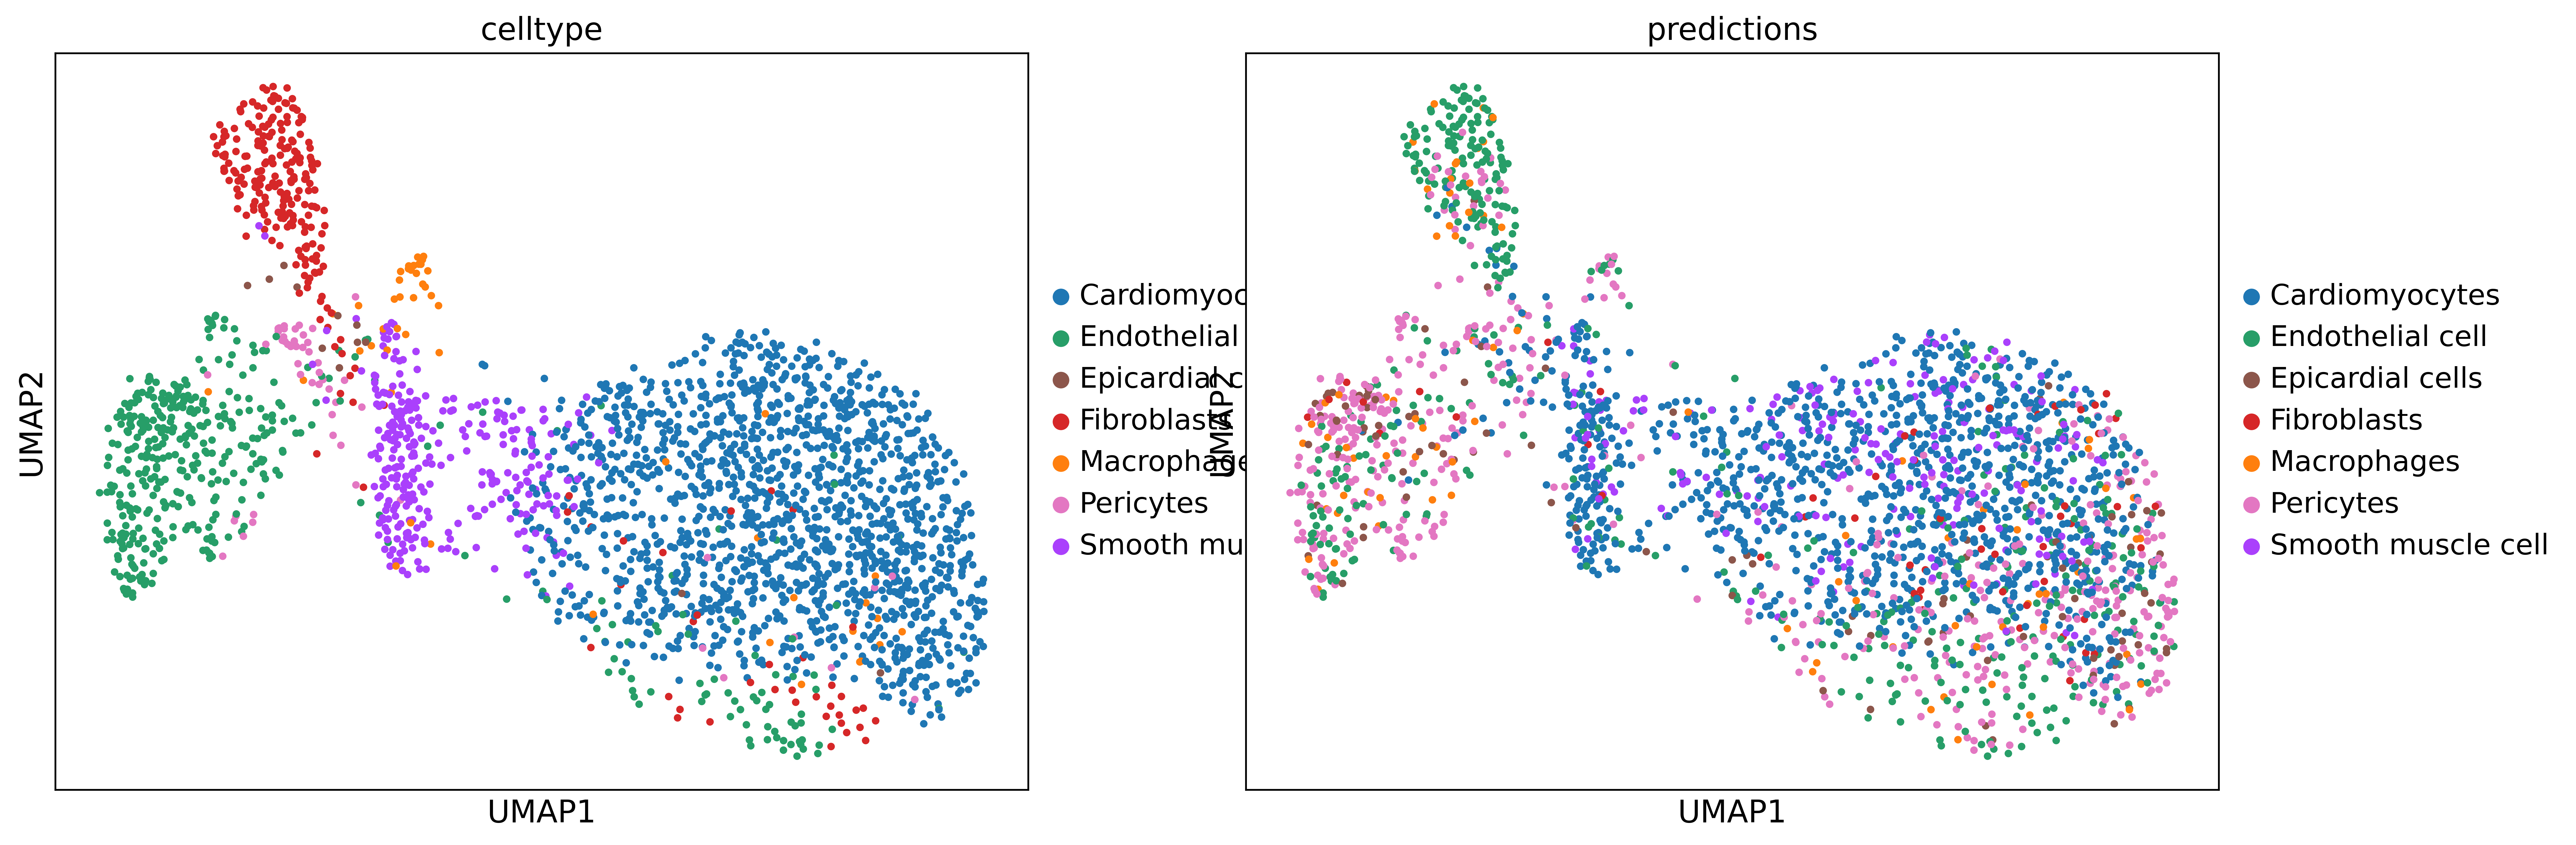

In [137]:
predictions, labels, results = test(best_model, adata_test)
adata_test_raw.obs["predictions"] = [id2type[p] for p in predictions]

# plot
palette_ = plt.rcParams["axes.prop_cycle"].by_key()["color"]
palette_ = plt.rcParams["axes.prop_cycle"].by_key()["color"] + plt.rcParams["axes.prop_cycle"].by_key()["color"] + plt.rcParams["axes.prop_cycle"].by_key()["color"]
palette_ = {c: palette_[i] for i, c in enumerate(celltypes)}

with plt.rc_context({"figure.figsize": (8, 6), "figure.dpi": (300)}):
    sc.pl.umap(
        adata_test_raw,
        color=["celltype", "predictions"],
        palette=palette_,
        show=False,
    )
    plt.savefig(save_dir / "results.png", dpi=300)

save_dict = {
    "predictions": predictions,
    "labels": labels,
    "results": results,
    "id_maps": id2type
}
with open(save_dir / "results.pkl", "wb") as f:
    pickle.dump(save_dict, f)

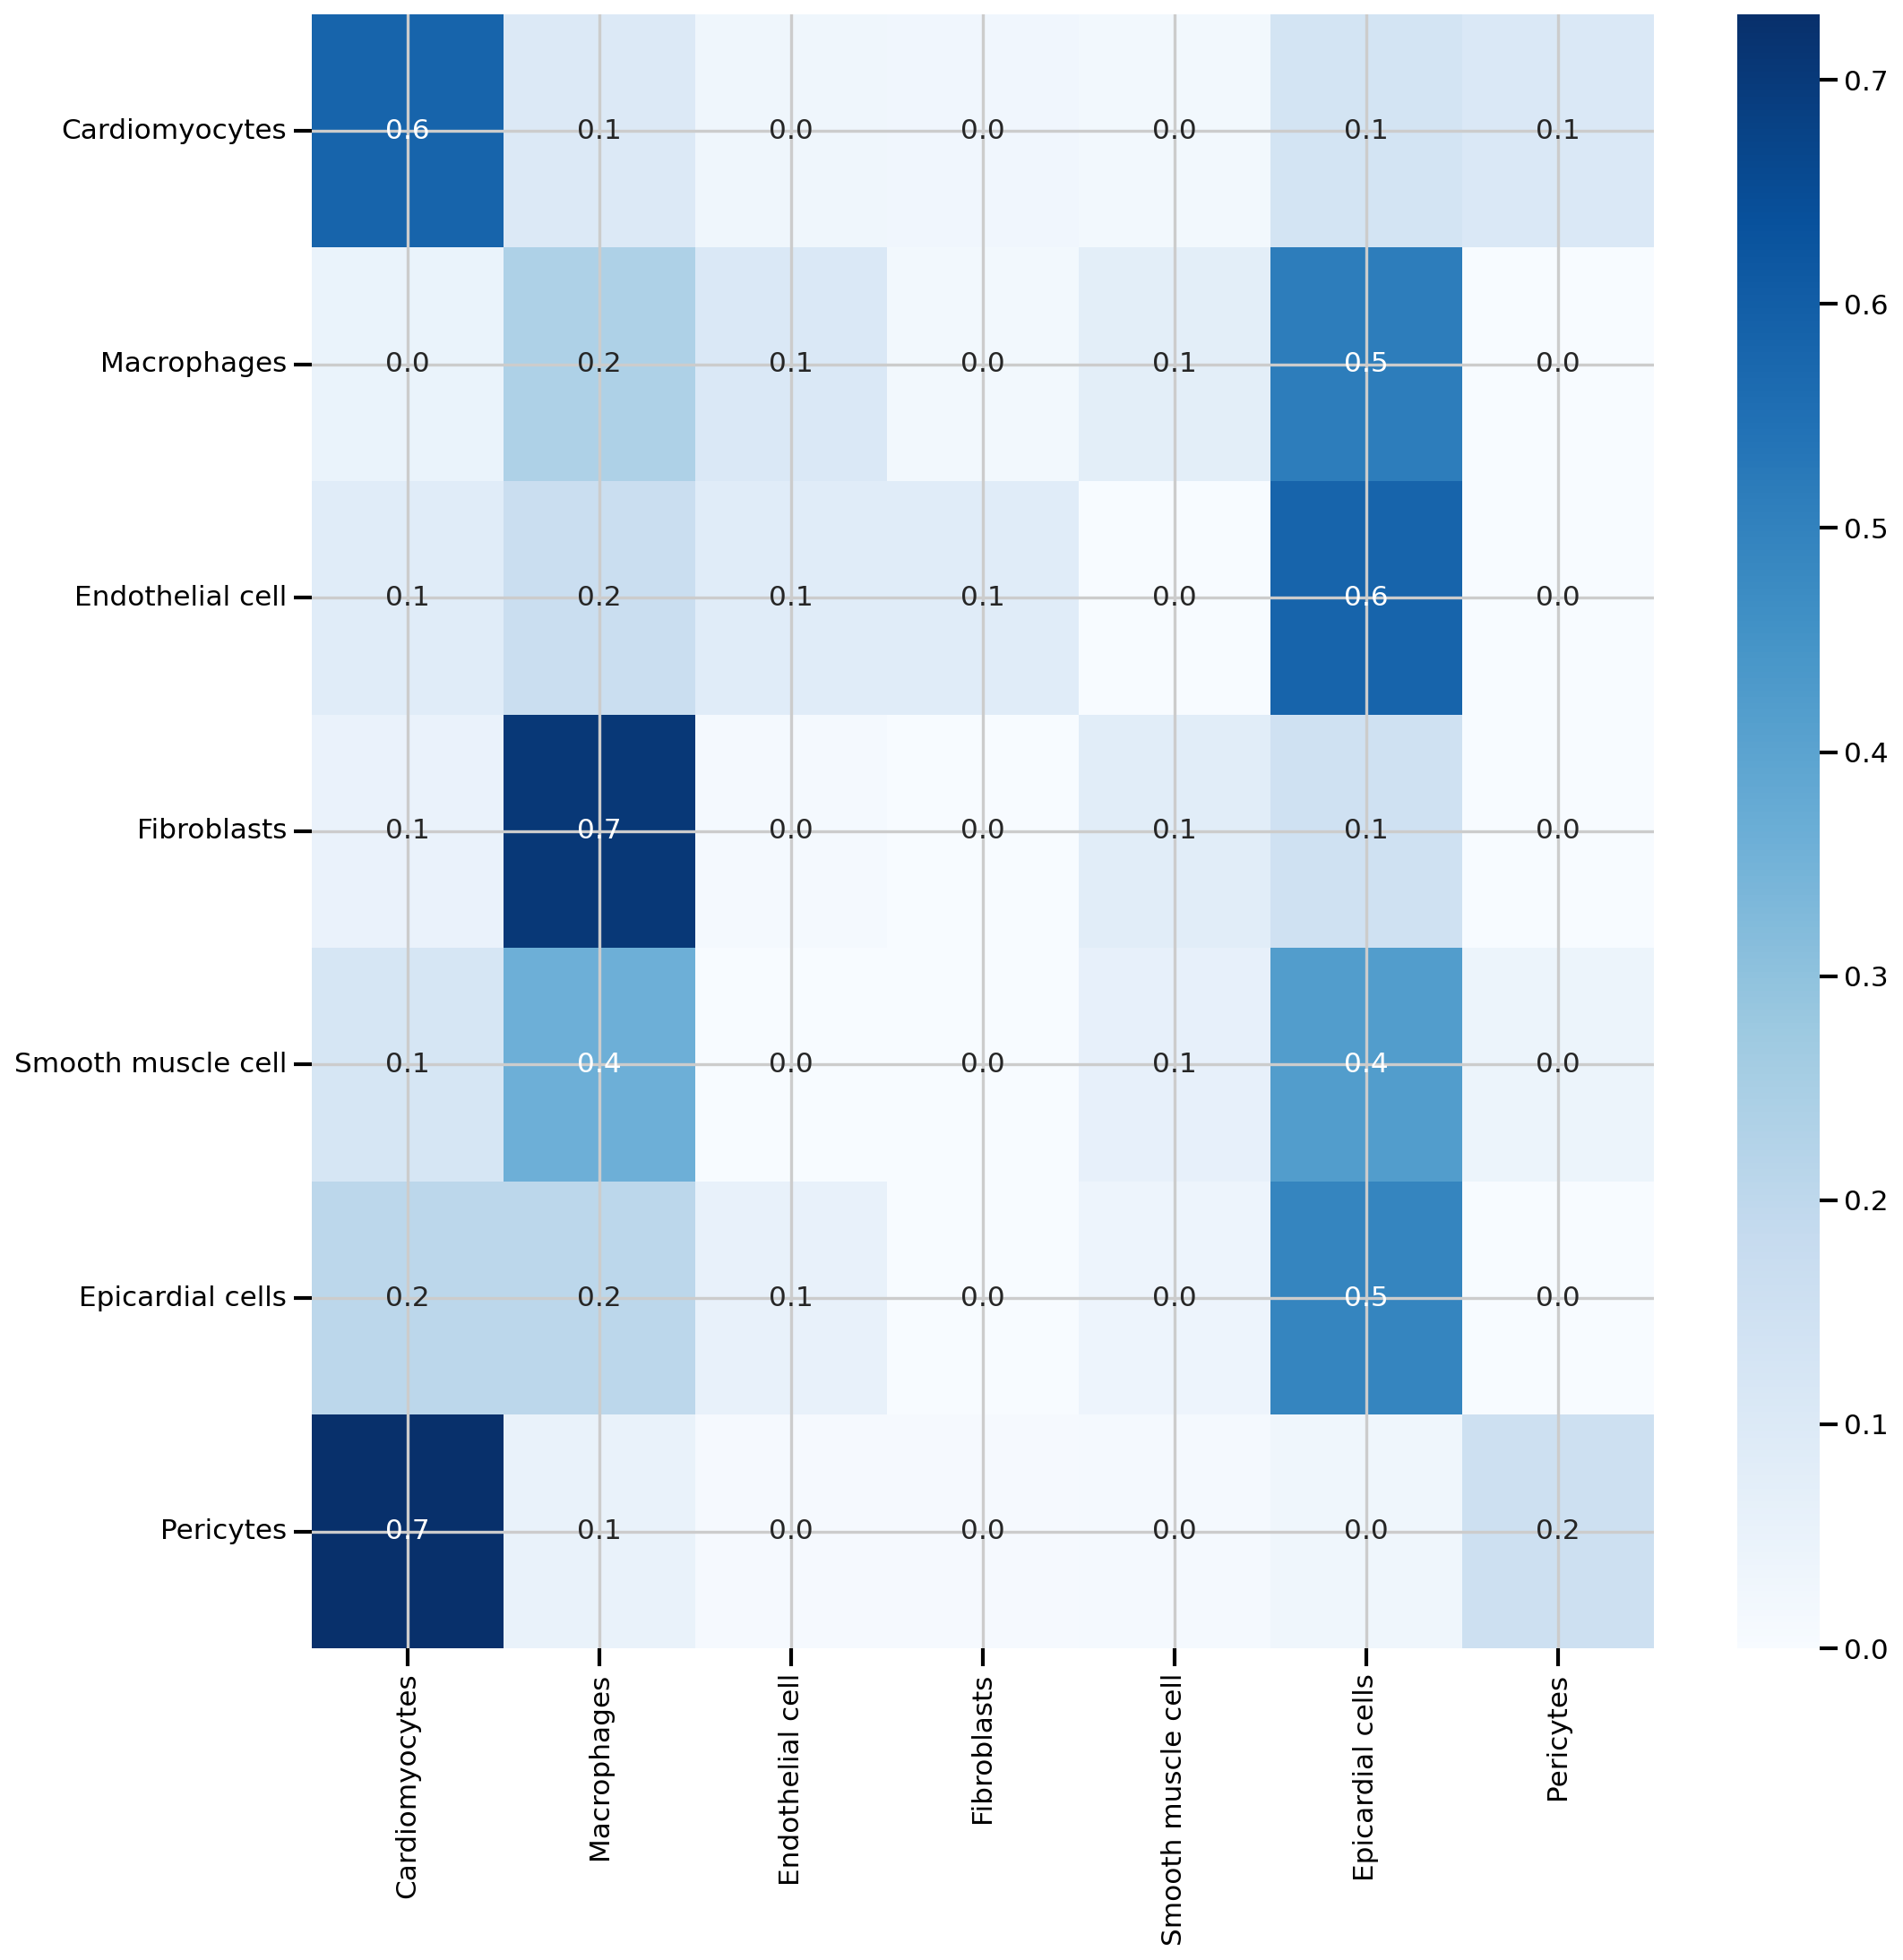

In [138]:
from sklearn.metrics import confusion_matrix
celltypes = list(celltypes)
for i in set([id2type[p] for p in predictions]):
    if i not in celltypes:
        celltypes.remove(i)
cm = confusion_matrix(labels, predictions)
cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
cm = pd.DataFrame(cm, index=celltypes[:cm.shape[0]], columns=celltypes[:cm.shape[1]])
plt.figure(figsize=(15, 15))
sns.heatmap(cm, annot=True, fmt=".1f", cmap="Blues")
plt.savefig(save_dir / "confusion_matrix.png", dpi=300)